# SMS Spam Classification
This is a text corpus of over 5,500 English SMS messages with ~13% labeled as spam. The text file contains one message per line with two columns: the label ("ham" or "spam") and the raw text of the message. Messages labeled as "ham" are non-spam messages that can be considered legitimate. 

## Exploratory Data Analysis
Import the necessary modules to do some Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np

data = pd.read_csv("SMSSpamCollection.csv", header=None, names = ['Classifier','Text'])
data.sample(10)

,Classifier,Text
2344,ham,1) Go to write msg 2) Put on Dictionary mode 3...
3873,ham,I am joining today formally.Pls keep praying.w...
3719,ham,Cool. Do you like swimming? I have a pool and ...
4660,ham,I cant pick the phone right now. Pls send a me...
4343,ham,Ha! I wouldn't say that I just didn't read any...
28,ham,"I'm back &amp; we're packing the car now, I'll..."
272,ham,"Night has ended for another day, morning has c..."
2256,ham,"I just lov this line: ""Hurt me with the truth,..."
2945,spam,We currently have a message awaiting your coll...
2361,ham,Had the money issue weigh me down but thanks t...


Split the data into the individual groups, allowing individual word clouds to be created for each one. 

In [2]:
ham_data = data[data['Classifier'] == 'ham']['Text'].tolist()
spam_data = data[data['Classifier'] == 'spam']['Text'].tolist()
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [3]:
def clean(arr):
    '''This function takes in an array, joins each element together. Using spacy the list is tokenised. Each token is lemmatised       checked if it not a stopword and then returns a cleaned array.'''
    arr_list = ' '.join(arr)
    arr_doc = nlp(arr_list)
    arr_token = [token.lemma_ for token in arr_doc]
    print('Tokens before cleaning {}'.format(len(arr_token)))
    arr_cleaned = [token for token in arr_token if token not in stopwords]
    print('Tokens after cleaning {}'.format(len(arr_cleaned)))
    arr_final = ' '.join(arr_cleaned)
    return arr_final

In [4]:
ham_cleaned = clean(ham_data)

Tokens before cleaning 82990
Tokens after cleaning 49741


In [5]:
spam_cleaned = clean(spam_data)

Tokens before cleaning 21581
Tokens after cleaning 15582


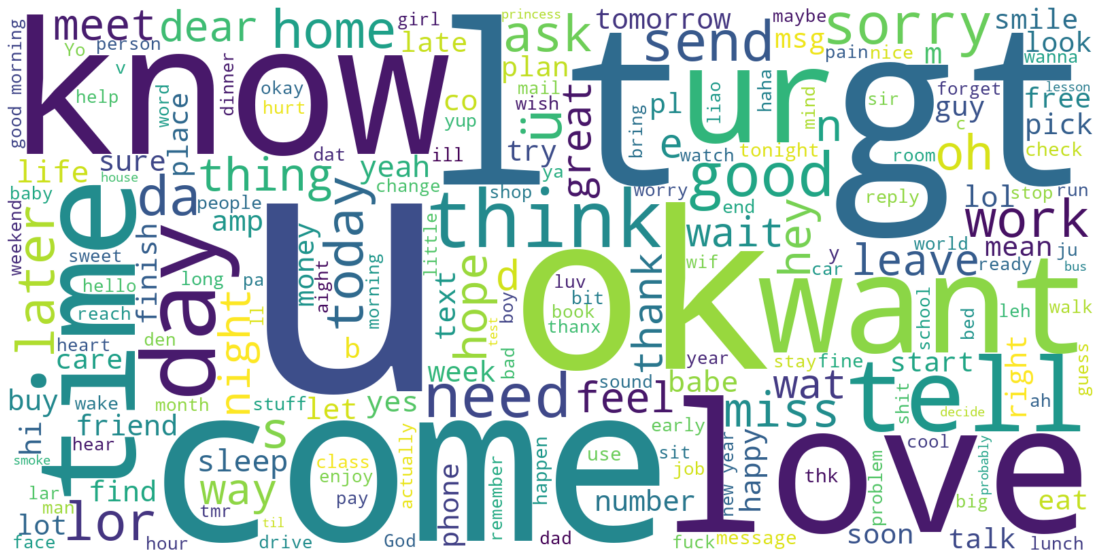

In [6]:
# not spam wordcloud generated
wordcloud_ham = WordCloud(width=1600, height=800,background_color='white', random_state = 1234).generate(ham_cleaned)

plt.figure( figsize=(20,10))
plt.imshow(wordcloud_ham, interpolation='bilInear')
plt.axis('off')
plt.show()

As you can see from the non spam wordcloud above, words tend to be short or abbreviated, rarely seeing words over 4 letters. Based on the words could make the assumption that the messages are between friends making plans. 

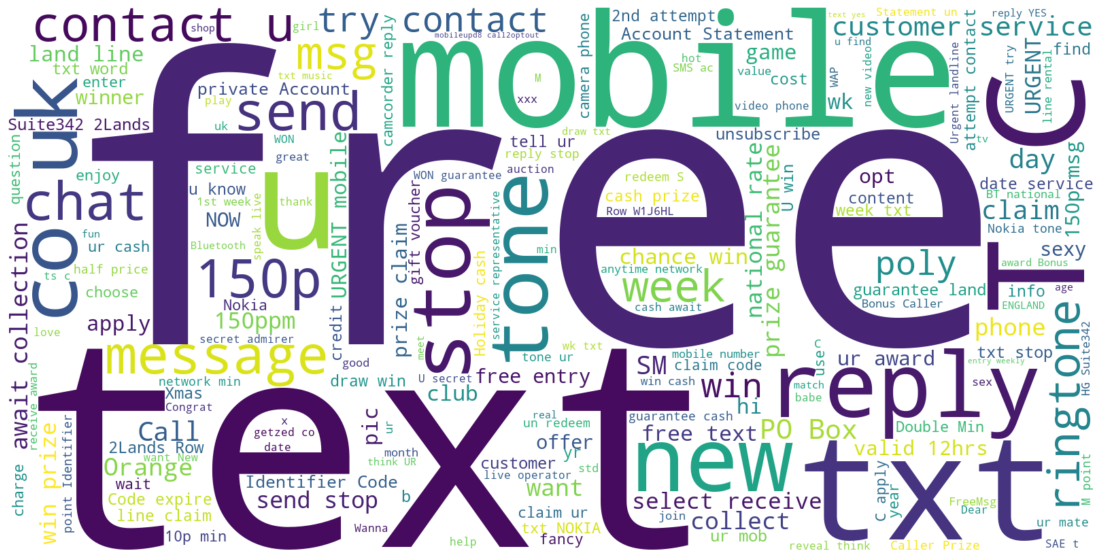

In [7]:
# not spam wordcloud generated
wordcloud_ham = WordCloud(width=1600, height=800,background_color='white', random_state = 1234).generate(spam_cleaned)

plt.figure( figsize=(20,10))
plt.imshow(wordcloud_ham, interpolation='bilInear')
plt.axis('off')
plt.show()

From the spam wordcloud can see that the most popular words are: free, text, reply. Based of this we can assume the context of the messages is to entice someone into replying to get something free. 

In [8]:
# Top 5 most popular words for non spam
ham_text_dict = WordCloud().process_text(ham_cleaned)
ham_freq = {k: v for k, v in sorted(ham_text_dict.items(),reverse=True, key=lambda item: item[1])}
print(list(ham_freq.items())[:5])

[('u', 919), ('lt gt', 276), ('come', 267), ('ok', 266), ('know', 233)]


In [9]:
# Top 5 most popular words for spam
spam_text_dict = WordCloud().process_text(spam_cleaned)
spam_freq = {k: v for k, v in sorted(spam_text_dict.items(),reverse=True, key=lambda item: item[1])}
print(list(spam_freq.items())[:5])

[('free', 157), ('text', 116), ('mobile', 92), ('txt', 79), ('u', 75)]


## Data Preprocessing

Steps for preprocessing

- Perform lemmatisation
- Remove stopwords
- Remove unecessary punctuation, want to keep repeated sets of punctuation like '...' as this reflects what is commonly seen in texting

Will not force all words to be lowercase as scam messages tend to be uppercase, helping the model to differentiate between the two types of messages.

In [10]:
def preprocess(x):
    '''This function takes in a string, tokenises, lemmatises and removes any stopwords. It then removes uneccessary punctuation        keeping only repeated sets (e.g ...), words or numbers returning a cleaned string'''
    doc = nlp(x)
    x_lemma = [text.lemma_ for text in doc if text.lemma_ not in stopwords]
    x_joined = ' '.join(x_lemma)
    x_split = re.findall('\w+|[!,.]{2,3}|\d+',x_joined)
    x_joined = ' '.join(x_split)
    return x_joined

In [11]:
data['Text_cleaned'] = data['Text'].apply(preprocess)

In [12]:
data.sample(10)

,Classifier,Text,Text_cleaned
4163,ham,How's it going? Got any exciting karaoke type ...,got exciting karaoke type activity plan I deba...
5257,ham,"As usual..iam fine, happy &amp; doing well..:)",usual .. iam fine happy amp ..
2078,ham,Hey hun-onbus goin 2 meet him. He wants 2go ou...,hey hun onbus goin 2 meet want 2go 4a meal I d...
3749,ham,"A bit of Ur smile is my hppnss, a drop of Ur t...",bit ur smile hppnss drop ur tear sorrow ur hea...
4691,ham,Ok no prob,ok prob
3658,ham,Studying. But i.ll be free next weekend.,study i ll free weekend
2815,ham,"Alright if you're sure, let me know when you'r...",alright sure let I know leave
5215,ham,I keep ten rs in my shelf:) buy two egg.,I rs shelf buy egg
3763,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,free 1st week No1 Nokia tone 4 ur mob week txt...
2025,ham,U having lunch alone? I now so bored...,u lunch I bored ...


## Machine Learning

Will be using TfidfVectorizer to transform and then input it for MultinomialNB and LinearSVC models. These will then be evaluated, using various metrics, to decide which is better. 

In [13]:
# Import relevant modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

### Helper Functions
Below are two helper functions to help visualise plots.

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, labels, title='Confusion Matrix', color = plt.cm.Blues):
    '''This function takes in the confusion matrix, its labels, title of the plot and its colour scheme, outputting a confusion         matrix'''
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_plot.plot(cmap = color)
    cm_plot.ax_.set_title(title)
    plt.show()
    return

In [15]:
def plot_roc(y_true, y_proba, model = 'Model', pos = 'spam'):
    '''This function takes in the true labels, positive predicted probabilities, name of the model, and the label of the positive       class. Prints the achieved ROC AUC score and outputs the ROC curve'''
    roc_score = metrics.roc_auc_score(y_true, y_proba)
    print(model +' achieved a ROC AUC score of {:0.2f}'.format(roc_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=pos) 
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_score) 
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(model +' ROC Curve') 
    plt.legend(loc="lower right") 
    plt.show()
    return

In [16]:
# split data into X and y
X,y = data['Text_cleaned'], data['Classifier']

# stratify to make sure proportional number of lables in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1234)

In [17]:
tfidf = TfidfVectorizer(lowercase = False)
# fit and transform X_train, and transform X_test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [18]:
# create MultinomialNB model
mnb = MultinomialNB()

# fit on training data and predict test labels
mnb.fit(X_train_tfidf, y_train)
y_test_pred_mnb = mnb.predict(X_test_tfidf)

# extract the positive probability class
y_test_pred_mnb_prob = mnb.predict_proba(X_test_tfidf)[:,1]

# perform 5 fold cross validation
cv_scores_mnb = cross_val_score(mnb, X_train_tfidf, y_train, cv = 5)

# calculate the mean and standard deviation of the cross validation scores
train_cv_mnb_mean, train_cv_mnb_std = np.mean(cv_scores_mnb), np.std(cv_scores_mnb)

# calculate the test accuracy
test_mnb_accuracy = metrics.accuracy_score(y_test, y_test_pred_mnb)

# printing scores
print("MultinomialNB Train CV accuracy mean is {:0.2f}, Train CV accuracy std {:0.3f}" .format(train_cv_mnb_mean, train_cv_mnb_std))
print("MultinomialNB Test accuracy is {:0.3f}" .format(test_mnb_accuracy))

MultinomialNB Train CV accuracy mean is 0.96, Train CV accuracy std 0.002
MultinomialNB Test accuracy is 0.969


The MultinomialNB model achieved a test accuracy of 96.9%. Performing a 5 fold cross validation on the training data achieved a mean score of 96% with a standard deviation of 0.2%, indicating that the model hasn't overfit and still generalises well to new data. To further analyse the model the ROC AUC score will be calculated and the confusion matrix will be plotted. 

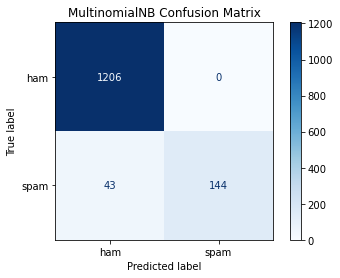

In [19]:
%matplotlib inline

# Creating and plotting a confusion matrix
mnb_cm = metrics.confusion_matrix(y_test, y_test_pred_mnb, labels = ['ham','spam'])
plot_confusion_matrix(mnb_cm, labels = ['ham','spam'], title = 'MultinomialNB Confusion Matrix')

MultinomialNB achieved a ROC AUC score of 0.98


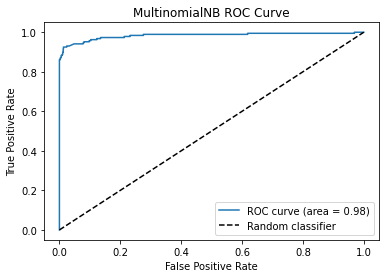

In [20]:
# plotting the ROC curve for the MultinomialNB model
plot_roc(y_test, y_test_pred_mnb_prob, 'MultinomialNB', pos = 'spam')

The confusion matrix for the MultinomialNB shows that the model performs very well. The model never incorrectly predicts a non-spam email as spam. This is reinforced by the ROC AUC score of 0.98 showing it is much better than a random classifier. 

In [21]:
# to get the probabilities will have to use CalibratedClassiferCV with LinearSVC 
svc = LinearSVC()
model_svc = CalibratedClassifierCV(svc)

# fit the LinearSVC on the training data and predict the y labels
model_svc.fit(X_train_tfidf, y_train)
y_test_pred_svc = model_svc.predict(X_test_tfidf)

# perform 5 fold cross validation 
cv_scores_svc = cross_val_score(model_svc, X_train_tfidf, y_train, cv = 5)

# calculate the mean and standard deviation of the cross validation scores
train_cv_svc_mean, train_cv_svc_std = np.mean(cv_scores_svc), np.std(cv_scores_svc)

# calculate the test accuracy 
test_svc_accuracy = metrics.accuracy_score(y_test, y_test_pred_svc)

# extract the probability of the positive class
y_test_pred_svc_prob = model_svc.predict_proba(X_test_tfidf)[:,1]

# printing the accuracy scores
print('Linear SVC Train CV accuracy mean is {:0.2f}, Train CV accuracy std {:0.3f}'.format(train_cv_svc_mean, train_cv_svc_std))
print('Linear SVC Test accuracy is {:0.3f}'.format(test_svc_accuracy))

Linear SVC Train CV accuracy mean is 0.98, Train CV accuracy std 0.003
Linear SVC Test accuracy is 0.984


The LinearSVC model achieved a test accuracy of 98.4%, outperforming the MultinomialNB model. Performing a 5 fold cross validation on the training data achieved a mean score of 98% with a standard deviation of 0.3%, indicating that the model hasn't overfit and still generalises well to new data. To further analyse the model the ROC AUC score will be calculated and the confusion matrix will be plotted. 

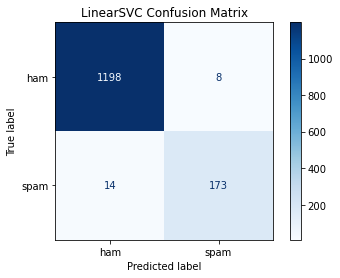

In [22]:
%matplotlib inline

# creating and printing confusion matrix
svc_cm = metrics.confusion_matrix(y_test, y_test_pred_svc, labels = ['ham','spam'])
plot_confusion_matrix(svc_cm, labels = ['ham','spam'], title = 'LinearSVC Confusion Matrix')

LinearSVC achieved a ROC AUC score of 0.99


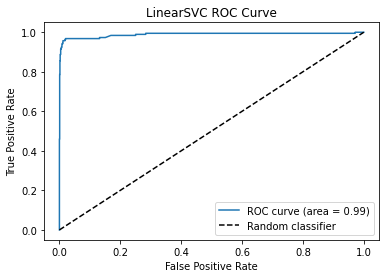

In [23]:
# plotting ROC curve
plot_roc(y_test, y_test_pred_svc_prob, 'LinearSVC', pos = 'spam')

The confusion matrix for the LinearSVC shows that the model slightly outperforms the MultinomialNB model. It is better at predicting spam emails, however this comes at the cost of predicting a few non-spam as spam. It also achieves an ROC AUC of 0.99 supporting the fact that this model is slightly better than the MultinomialNB model

## Hyperparamter Tuning Linear SVC

Will tune the MultinomialNB model to improve it and potentially be equal to the LinearSVC model. Will be tuuning the alpha parameter which controls the smoothing in the model

In [24]:
# creating dictionary of alpha values to search over
param_grid = {'alpha' : np.arange(0.1,2,0.1)}

mnb = MultinomialNB()

# fit model Gridsearch model on training data, using 5 folds
model_mnb_cv = GridSearchCV(mnb, param_grid, cv = 5)
model_mnb_cv.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])})

In [25]:
#Printing optimal paramters and score
print('The best parameter for alpha is {:0.2f}, best score was {:0.2f}'.format(model_mnb_cv.best_params_['alpha'], model_mnb_cv.best_score_))

The best parameter for alpha is 0.30, best score was 0.98


In [26]:
# extracting the best model
best_model = model_mnb_cv.best_estimator_

# using the best model to predict new y labels
y_best = best_model.predict(X_test_tfidf)

# calculating the accuracy
best_accuracy = metrics.accuracy_score(y_test, y_best)

# printing the new accuracy
print('The improved accuracy for MultinomialNB model is {:0.2f}'.format(best_accuracy))

The improved accuracy for MultinomialNB model is 0.98


As a result of the hyperparameter tuning the accuracy improved, while marginal, to 98%. The tuned model is now on par with the the LinearSVC model. 